In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates

%matplotlib inline
sns.set()

In [2]:
bq_sql = """
    SELECT 
      county, 
      DATE_TRUNC(date, MONTH) AS month, 
      SUM(bottles_sold) AS total_bottles_sold,
      SUM(sale_dollars) AS total_sale_dollars
    FROM `bigquery-public-data.iowa_liquor_sales.sales` 
    WHERE county IS NOT NULL 
    GROUP BY 1,2
    ORDER BY 1,2
"""

In [3]:
df = pd.read_csv('./dataset/iowa_liquor_sales_data.csv')
df['month'] = pd.to_datetime(df['month'])
df = df[df['month'] >= pd.to_datetime('2017-01-01')]
df.head(10)

,county,month,total_bottles_sold,total_sale_dollars
60,ADAIR,2017-01-01,2518,31244.90
61,ADAIR,2017-02-01,2809,33261.11
62,ADAIR,2017-03-01,2840,34963.50
63,ADAIR,2017-04-01,2737,31647.23
64,ADAIR,2017-05-01,3346,41225.80
65,ADAIR,2017-06-01,3390,41180.29
66,ADAIR,2017-07-01,2834,35042.01
67,ADAIR,2017-08-01,3416,42307.28
68,ADAIR,2017-09-01,2828,34665.73
69,ADAIR,2017-10-01,3009,38952.96


## Selecting Top 10 County

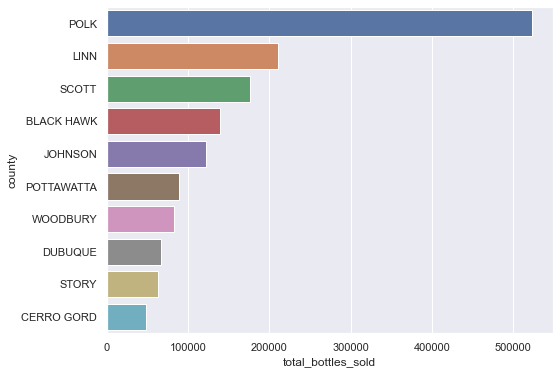

In [4]:
df_agg = df.groupby(['county'])['total_bottles_sold'].mean().reset_index()
df_agg = df_agg.sort_values(['total_bottles_sold'], ascending = False).reset_index(drop = True)
df_agg = df_agg.head(10)

data = df_agg
fig, axs = plt.subplots(1,1, figsize = (8,6))
sns.barplot(ax = axs, data = data, x = 'total_bottles_sold', y = 'county')
plt.show()

In [5]:
county_top10 = df_agg['county']
df_top10 = df[df['county'].isin(county_top10)]

df_top10.groupby(['county']).agg({'month': ['min', 'max'], 
                                  'total_bottles_sold' : ['sum', 'mean', 'min', 'max'],
                                  'total_sale_dollars' : ['sum', 'mean', 'min', 'max'],
                                 })

month            total_bottles_sold                         \
                  min        max                sum           mean     min   
county                                                                       
BLACK HAWK 2017-01-01 2022-11-01            9919692  139713.971831  104997   
CERRO GORD 2017-01-01 2022-11-01            3448657   48572.633803   30570   
DUBUQUE    2017-01-01 2022-11-01            4738571   66740.436620   48626   
JOHNSON    2017-01-01 2022-11-01            8653791  121884.380282   89910   
LINN       2017-01-01 2022-11-01           14942203  210453.563380  145204   
POLK       2017-01-01 2022-11-01           37116041  522761.140845  331263   
POTTAWATTA 2017-01-01 2022-11-01            6326387   89104.042254   52971   
SCOTT      2017-01-01 2022-11-01           12537147  176579.535211  119230   
STORY      2017-01-01 2022-11-01            4524736   63728.676056   43379   
WOODBURY   2017-01-01 2022-11-01            5885513   82894.549296   51308   

                   total_sale_dollars                                         
               max                sum          mean         min          max  
county                                                                        
BLACK HAWK  182205       1.207120e+08  1.700169e+06  1172912.12   2469555.20  
CERRO GORD   69334       4.580596e+07  6.451543e+05   387034.74    968972.58  
DUBUQUE      87591       6.504532e+07  9.161313e+05   656988.72   1251688.41  
JOHNSON     168885       1.291922e+08  1.819609e+06  1260581.83   2619967.96  
LINN        261475       1.899042e+08  2.674707e+06  1818928.71   3570554.29  
POLK        686876       5.104696e+08  7.189713e+06  4249705.87  10612080.56  
POTTAWATTA  133459       7.917157e+07  1.115092e+06   664207.74   1735237.26  
SCOTT       244089       1.557075e+08  2.193064e+06  1350466.43   3119546.13  
STORY        95802       6.629048e+07  9.336688e+05   590399.14   1458754.48  
WOODBURY    113905       7.581096e+07  1.067760e+06   629576.91   1535531.89

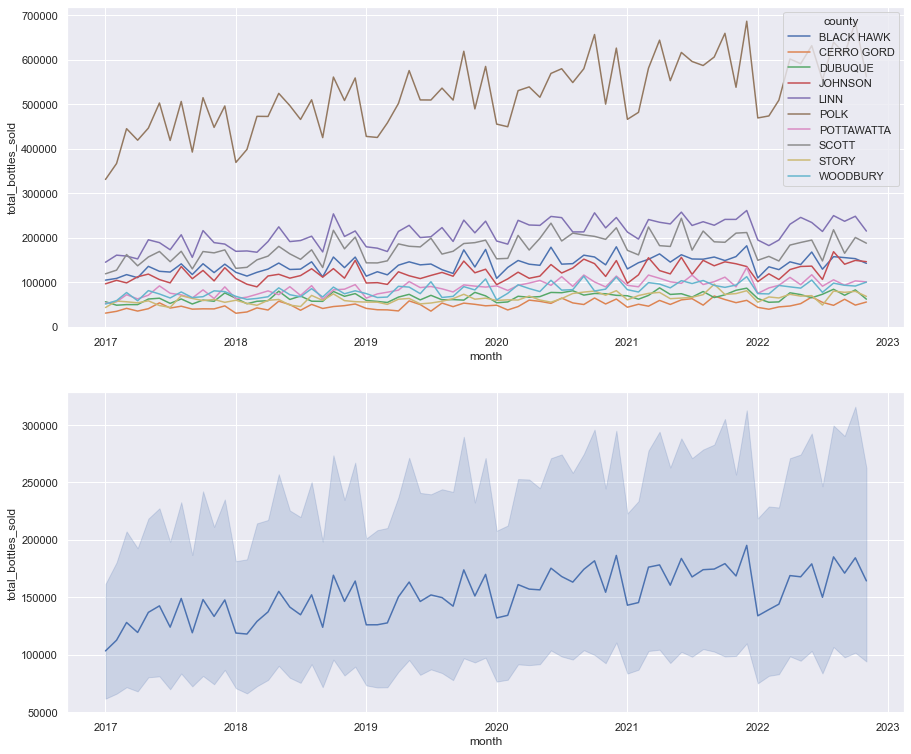

In [6]:
data = df_top10

fig, axs = plt.subplots(2,1, figsize = (15,13))
sns.lineplot(ax = axs[0], data = data, x = 'month', y = 'total_bottles_sold', hue = 'county')
sns.lineplot(ax = axs[1], data = data, x = 'month', y = 'total_bottles_sold')
plt.show()

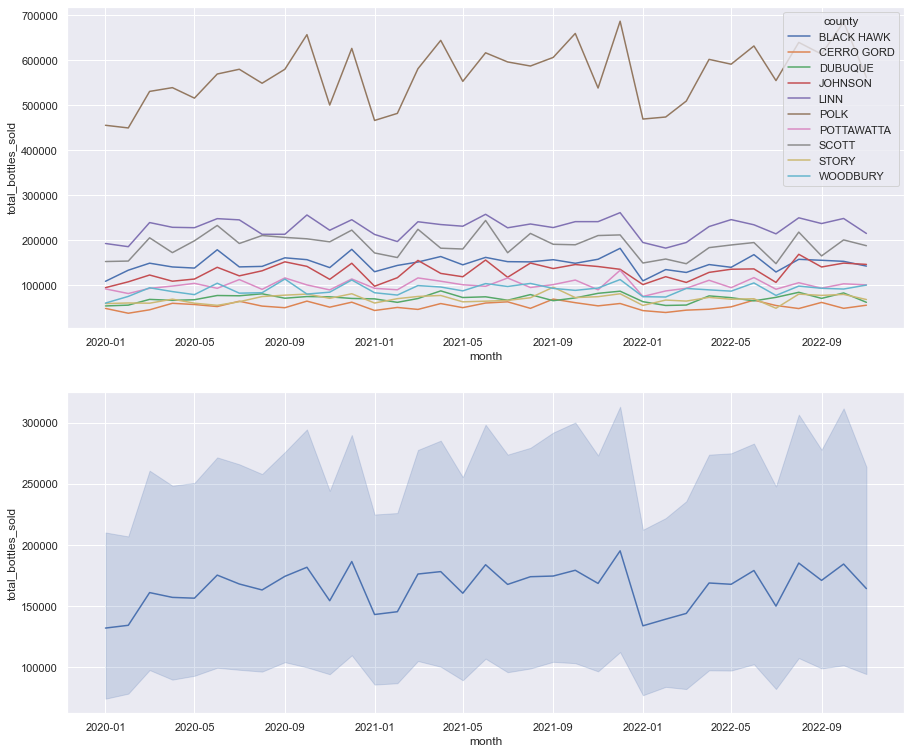

In [7]:
data = df_top10[df_top10['month'] >= pd.to_datetime('2020-01-01')]

fig, axs = plt.subplots(2,1, figsize = (15,13))
sns.lineplot(ax = axs[0], data = data, x = 'month', y = 'total_bottles_sold', hue = 'county')
sns.lineplot(ax = axs[1], data = data, x = 'month', y = 'total_bottles_sold')
plt.show()

## Forecasting using Auto-ARIMA

### Preparing the data

In [9]:
def get_actual_data(data, date, values, category, start_date, end_date):
    data_pivot = pd.pivot_table(data, 
                                index = date,
                                values = values, 
                                columns = category, 
                                aggfunc=np.sum, 
                                fill_value=0)
    monthly_table = pd.DataFrame({'month' : pd.date_range(start = '2017-01-01', end = '2022-11-01', freq='MS')})
    data_result = monthly_table.merge(data_pivot, left_on = 'month', right_on = 'month', how = 'left').fillna(0)
    data_result = data_result.set_index('month')
    return data_result

In [10]:
df_actual = get_actual_data(data = df_top10, 
                            date = 'month', 
                            values = 'total_bottles_sold', 
                            category = 'county',
                            start_date = '2017-01-01', 
                            end_date = '2022-11-01')
df_actual

,BLACK HAWK,CERRO GORD,DUBUQUE,JOHNSON,LINN,POLK,POTTAWATTA,SCOTT,STORY,WOODBURY
month,,,,,,,,,,
2017-01-01,104997,30838,56452,96681,145204,331263,52971,119230,43379,51308
2017-02-01,108888,34876,48626,104546,161093,367128,56271,127445,57985,58903
2017-03-01,117375,41549,49938,98757,159013,445385,72176,162459,56314,77105
2017-04-01,110513,35439,49951,112436,152636,419458,62835,137160,53989,58619
2017-05-01,135958,40792,62544,118557,195646,446664,71086,156969,58491,81450
...,...,...,...,...,...,...,...,...,...,...
2022-07-01,129534,55095,73233,106431,214343,554940,91274,148087,48959,77494
2022-08-01,157712,48350,84466,168885,250014,639779,105731,218242,80414,98248
2022-09-01,155600,61994,70937,140723,237246,613717,93615,165289,77554,93360


### How Auto-ARIMA works?

In [8]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1403.137, Time=0.26 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1400.206, Time=0.04 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1402.901, Time=0.16 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=1403.039, Time=0.17 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1433.156, Time=0.03 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1401.493, Time=0.09 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=1401.364, Time=0.08 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1401.908, Time=0.07 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=1401.812, Time=0.07 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=1403.824, Time=0.12 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.128 seconds
                                SARIMAX Results                                 
Dep. Variable:                        y   No. Observations:                   71
Model:             SARIMAX(0, 1, 0, 12)   Log L

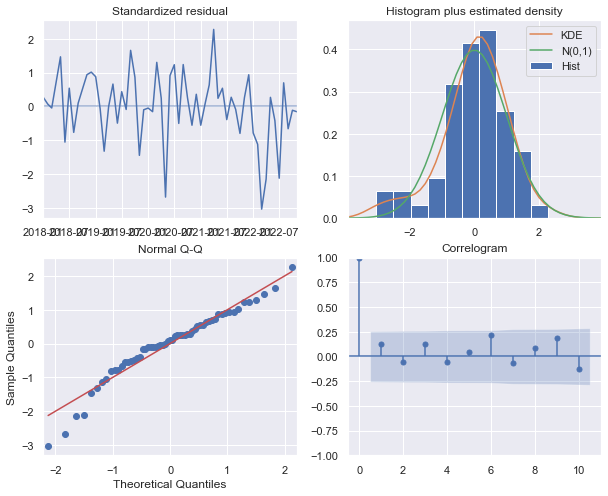

In [11]:
data_actual = df_actual['POLK']
seasonal = True

model = pm.auto_arima(data_actual, 
                      start_p=0, start_q=0,
                      max_p=12, max_q=12, # maximum p and q
                      test='adf',         # use adftest to find optimal 'd'
                      seasonal=seasonal,  # TRUE if seasonal series
                      m=12,               # frequency of series
                      d=None,             # let model determine 'd'
                      D=None,             # let model determine 'D'
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())
model.plot_diagnostics(figsize=(10,8))
plt.show()

### Forecast multiple series using Auto-ARIMA

In [12]:
def get_forecast_group(data, n_periods, seasonal):
    data_fc = []
    data_lower = []
    data_upper = []
    data_aic = []
    data_fitted = []
    for group in data.columns:
        data_actual = data[group]
        model = pm.auto_arima(data_actual, 
                              start_p=0, start_q=0,
                              max_p=12, max_q=12, # maximum p and q
                              test='adf',         # use adftest to find optimal 'd'
                              seasonal=seasonal,  # TRUE if seasonal series
                              m=12,               # frequency of series
                              d=None,             # let model determine 'd'
                              D=None,             # let model determine 'D'
                              trace=False,
                              error_action='ignore',  
                              suppress_warnings=True, 
                              stepwise=True)
        fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
        index_of_fc = pd.date_range(pd.to_datetime(data_actual.index[-1])  + relativedelta(months = +1), periods = n_periods, freq = 'MS')
        data_fc.append(fc)
        data_lower.append(confint[:, 0])
        data_upper.append(confint[:, 1])
        data_aic.append(model.aic())
        data_fitted.append(model.fittedvalues())

        df_fc = pd.DataFrame(index = index_of_fc)
        df_lower = pd.DataFrame(index = index_of_fc)
        df_upper = pd.DataFrame(index = index_of_fc)
        df_aic = pd.DataFrame()
        df_fitted = pd.DataFrame(index = data_actual.index)

    i = 0
    for group in data.columns:
        df_fc[group] = data_fc[i][:]
        df_lower[group] = data_lower[i][:]
        df_upper[group] = data_upper[i][:]
        df_aic[group] = data_aic[i]
        df_fitted[group] = data_fitted[i][:]
        i = i + 1
    
    return df_fc, df_lower, df_upper, df_aic, df_fitted

def get_combined_data(df_actual, df_forecast):
    data_actual = df_actual
    data_forecast = df_forecast
    
    data_actual['desc'] = 'Actual'
    data_forecast['desc'] = 'Forecast'
    
    df_act_fc = pd.concat([data_actual, data_forecast]).reset_index()
    df_act_fc = df_act_fc.rename(columns={'index': 'month'})

    return df_act_fc

def get_plot_fc(df_act_fc, df_lower, df_upper, df_fitted, nrow, ncol, figsize_x, figsize_y, category_field_values,  title, ylabel):
    years = mdates.YearLocator()    # every year
    months = mdates.MonthLocator()  # every month
    years_fmt = mdates.DateFormatter('%Y')

    df_melt = df_act_fc.melt(id_vars = ['month', 'desc'])
    df_melt_fitted = df_fitted.reset_index().melt(id_vars = ['month'])

    fig, axs = plt.subplots(nrow, ncol, figsize = (figsize_x,figsize_y))
    fig.suptitle(title, size = 20, y = 0.90)

    i = 0
    j = 0
    for cat in category_field_values:
        df_plot = df_melt[df_melt['variable'] == cat]
        df_lower_plot = df_lower[cat]
        df_upper_plot = df_upper[cat]
        df_plot_fitted = df_melt_fitted[df_melt_fitted['variable'] == cat]

        sns.lineplot(ax = axs[j,i], data = df_plot, x = 'month', y = 'value', hue = 'desc', marker = 'o')
        sns.lineplot(ax = axs[j,i], data = df_plot_fitted, x = 'month', y = 'value', dashes=True, alpha = 0.5)
        axs[j, i].set_xlabel(cat, size = 15)
        axs[j, i].set_ylabel(ylabel, size = 15)

        axs[j,i].fill_between(df_lower_plot.index, 
                      df_lower_plot, 
                      df_upper_plot, 
                      color='k', alpha=.15)

        axs[j,i].legend(loc = 'upper left')
        axs[j,i].set_ylim([df_plot['value'].min()-1000, df_plot['value'].max()+1000])

        axs[j,i].xaxis.set_major_locator(years)
        axs[j,i].xaxis.set_major_formatter(years_fmt)
        axs[j,i].xaxis.set_minor_locator(months)

        i = i + 1 
        if i >= ncol:
            j = j + 1
            i = 0

    plt.show()

In [13]:
df_fc, df_lower, df_upper, df_aic, df_fitted = get_forecast_group(data = df_actual, n_periods = 24, seasonal = True)

In [14]:
df_act_fc = get_combined_data(df_actual = df_actual, df_forecast = df_fc)

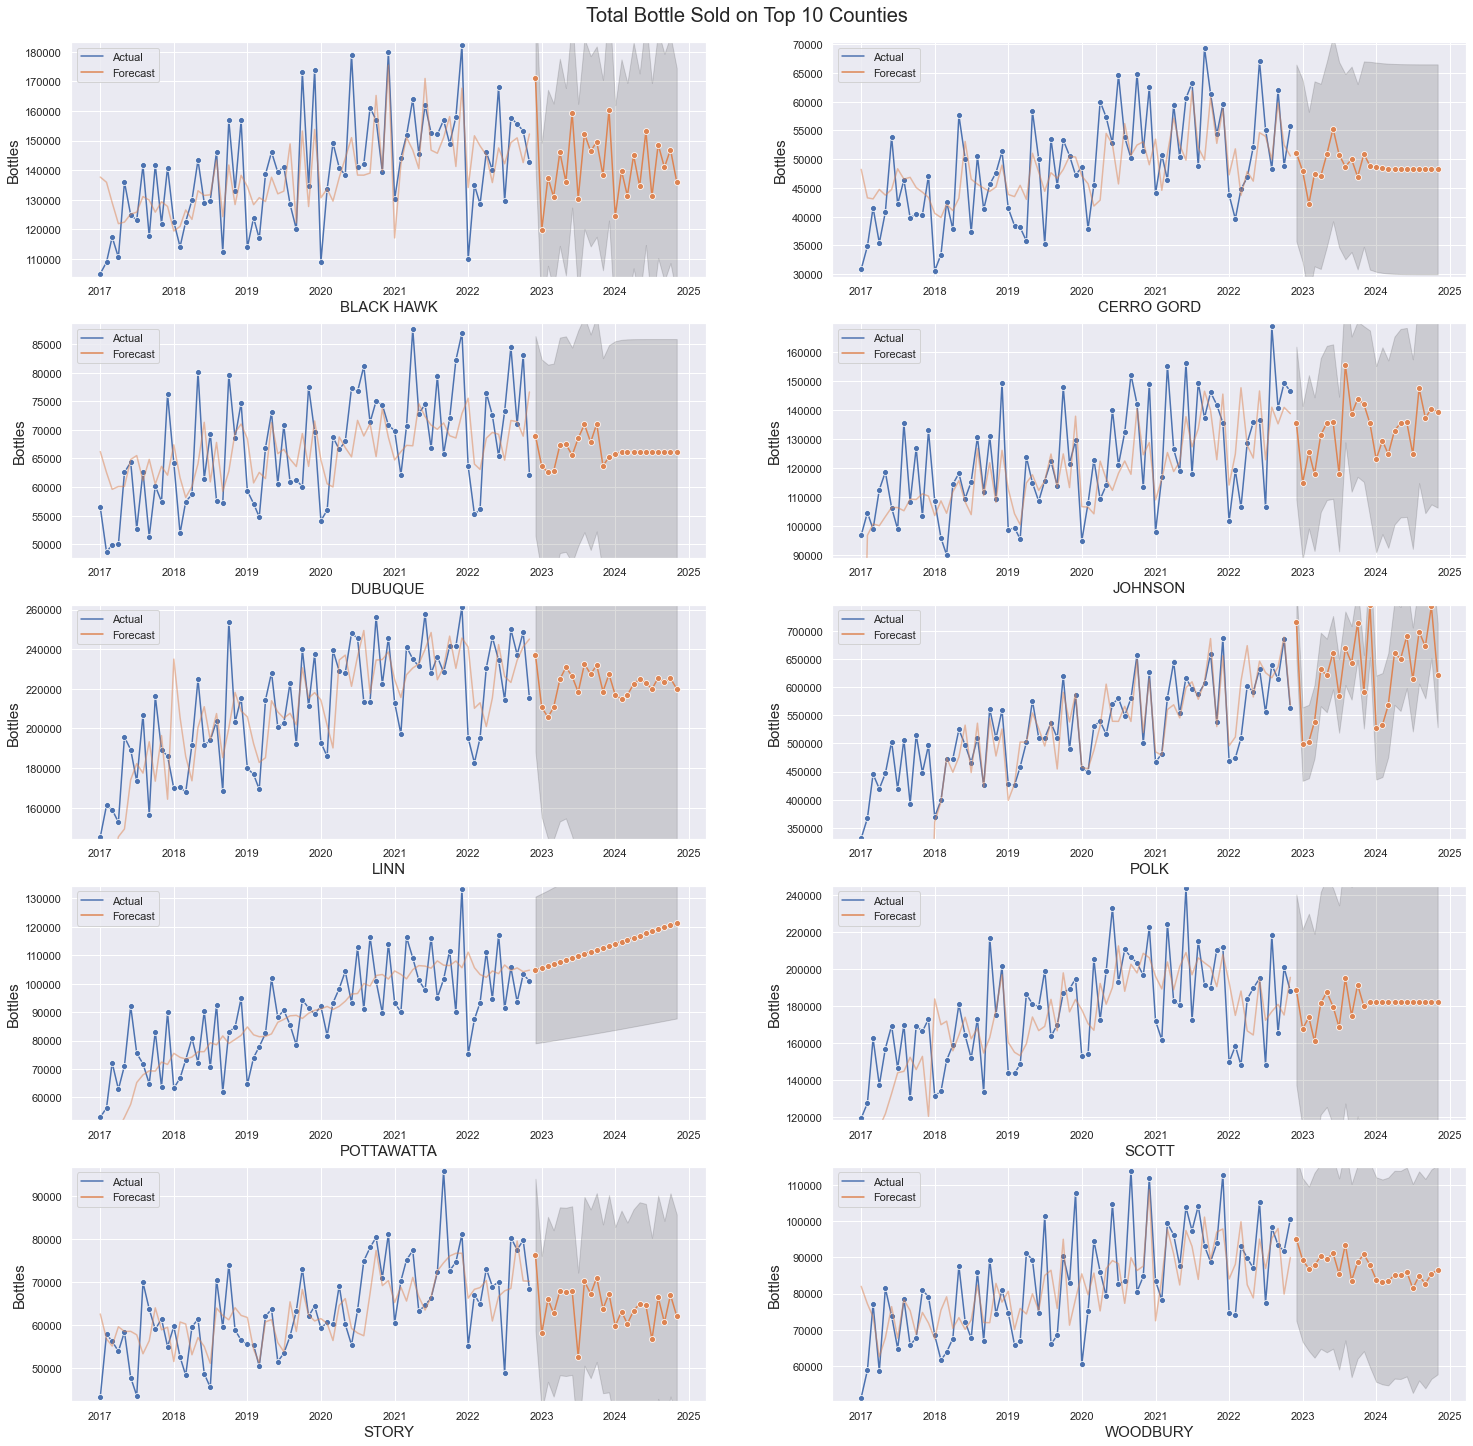

In [15]:
get_plot_fc(df_act_fc, 
            df_lower, 
            df_upper, 
            df_fitted,
            nrow = 5, ncol = 2, 
            figsize_x = 25, figsize_y = 25,
            category_field_values = df_act_fc.drop(['month', 'desc'], axis = 1).columns, 
            title = 'Total Bottle Sold on Top 10 Counties',
            ylabel = 'Bottles')